# Sentiment Analysis on IMDB movie Reviews

# Brief:
This notebook performs sentiment analysis on IMDb movie reviews to classify them as positive or negative.
It includes:
1. Loading and reading the IMDb dataset using Pandas.
2. Cleaning and preprocessing text (lowercasing, removing stopwords, punctuation, and HTML tags).
3. Visualizing the most frequent words in positive and negative reviews using bar charts.
4. Converting text to numerical format using TF-IDF vectorization.
5. Training and evaluating a Logistic Regression classifier.
6. Training and evaluating a Naive Bayes classifier, comparing its accuracy with Logistic Regression.
Tools used: Pandas, NLTK, Scikit-learn, Matplotlib.


### import depandencies

In [13]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Loading and exploring the IMDb dataset using Pandas.

In [6]:
data = pd.read_csv('IMDB Dataset.csv')

In [7]:
print("Dataset Info:")
print(data.info())
print("\nDataset Shape:", data.shape)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Dataset Shape: (50000, 2)


In [8]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
review       0
sentiment    0
dtype: int64



Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


/tmp/ipython-input-667334188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='Set2')


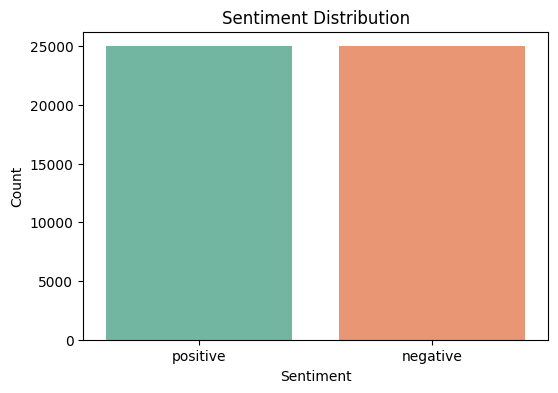

In [9]:
print("\nSentiment Distribution:")
print(data['sentiment'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=data, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

The dataset is well distributed between positive and negative reviews. This means there is no class imbalance, so the model will not be biased toward one sentiment. Both classes are equally represented, which ensures fair training and evaluation.


Review Length Statistics:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


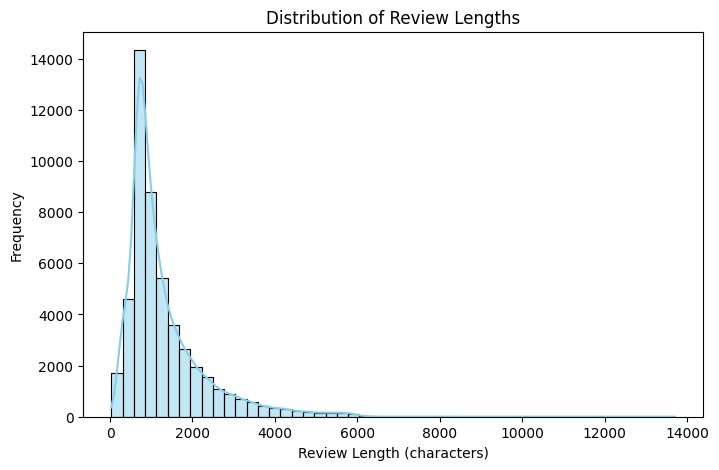

In [10]:
data['review_length'] = data['review'].apply(len)
print("\nReview Length Statistics:")
print(data['review_length'].describe())
plt.figure(figsize=(8, 5))
sns.histplot(data['review_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

The length analysis shows that most reviews are under 1000 characters, with some outliers being much longer. This information is important because TF-IDF performance depends on consistent document sizes.

### Cleaning and preprocessing text (lowercasing, removing stopwords, punctuation, and HTML tags).

In [11]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<br\s*/>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    words = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords and lemmatize
    return ' '.join(words)

In [12]:
data['cleaned_review'] = data['review'].apply(preprocess_text)

### Visualizing the most frequent words in positive and negative reviews using bar charts.

In [14]:
def plot_frequent_words(text, title, color='skyblue'):
    words = word_tokenize(text)
    freq = FreqDist(words).most_common(20)
    words, counts = zip(*freq)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color=color)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

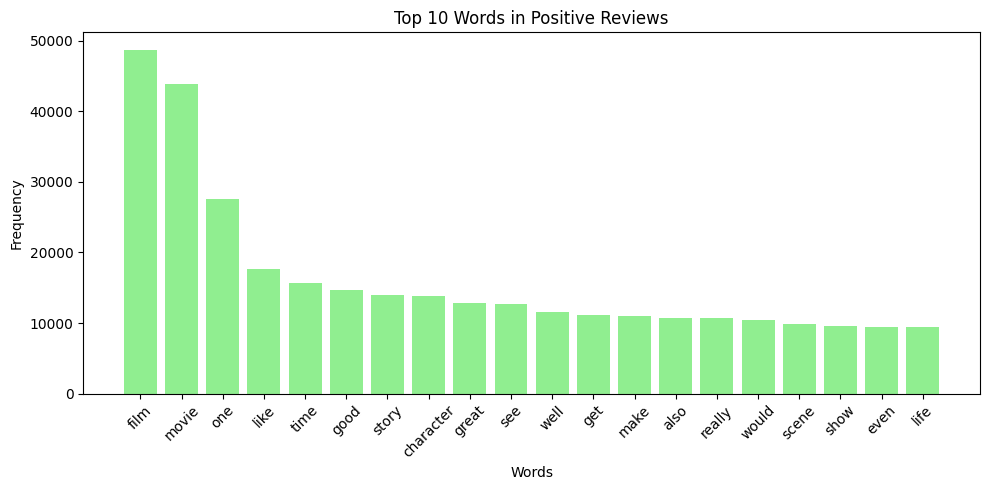

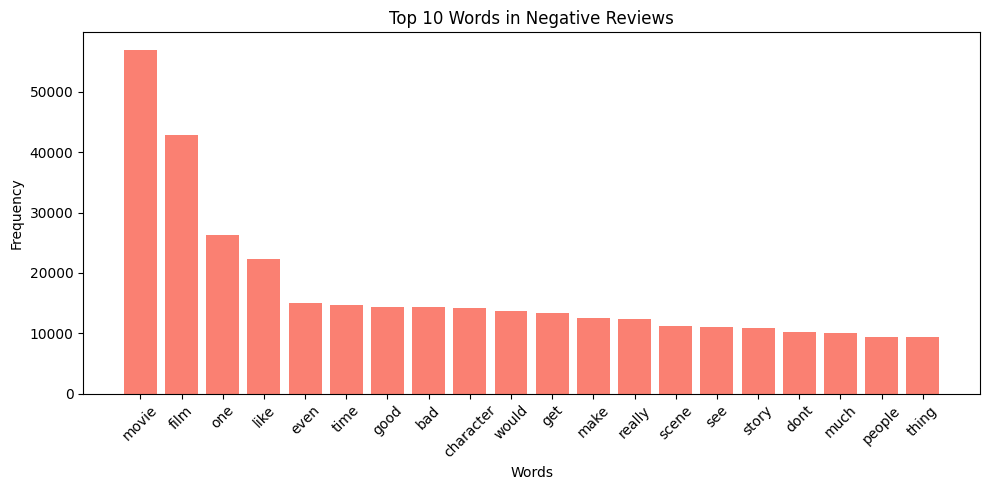

In [15]:
positive_text = ' '.join(data[data['sentiment'] == 'positive']['cleaned_review'])
negative_text = ' '.join(data[data['sentiment'] == 'negative']['cleaned_review'])
plot_frequent_words(positive_text, 'Top 10 Words in Positive Reviews', 'lightgreen')
plot_frequent_words(negative_text, 'Top 10 Words in Negative Reviews', 'salmon')

### Converting text to numerical format using TF-IDF vectorization

In [16]:
vectorizer = TfidfVectorizer(max_features=20000, min_df=6, max_df=0.9)
X = vectorizer.fit_transform(data['cleaned_review'])
y = data['sentiment'].map({'positive': 1, 'negative': 0})

### Training and evaluating a Logistic Regression and Naive Bayes classifiers

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")
print("Logistic Regression Performance Metrics:")
print(classification_report(y_test, lr_pred, target_names=['Negative', 'Positive']))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_pred))


Logistic Regression Accuracy: 0.8949
Logistic Regression Performance Metrics:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      6157
    Positive       0.89      0.91      0.90      6343

    accuracy                           0.89     12500
   macro avg       0.90      0.89      0.89     12500
weighted avg       0.90      0.89      0.89     12500

Logistic Regression Confusion Matrix:
[[5439  718]
 [ 596 5747]]


In [19]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"\nNaive Bayes Accuracy: {nb_accuracy:.4f}")
print("Naive Bayes Performance Metrics:")
print(classification_report(y_test, nb_pred, target_names=['Negative', 'Positive']))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, nb_pred))


Naive Bayes Accuracy: 0.8638
Naive Bayes Performance Metrics:
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      6157
    Positive       0.87      0.85      0.86      6343

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500

Naive Bayes Confusion Matrix:
[[5379  778]
 [ 924 5419]]


### Test Models in new reviews

In [20]:
def predict_sentiment(review, vectorizer, lr_model, nb_model):
    cleaned_review = preprocess_text(review)
    review_vector = vectorizer.transform([cleaned_review])
    lr_prediction = lr_model.predict(review_vector)[0]
    nb_prediction = nb_model.predict(review_vector)[0]
    return {
        'Logistic Regression Prediction': 'Positive' if lr_prediction == 1 else 'Negative',
        'Naive Bayes Prediction': 'Positive' if nb_prediction == 1 else 'Negative'
    }

In [25]:
new_review = input("Enter your movie review: ")
predictions = predict_sentiment(new_review, vectorizer, lr_model, nb_model)
print("\nSentiment Predictions for Your Review:")
for model, prediction in predictions.items():
    print(f"{model}: {prediction}")

Enter your movie review: this movie is great 

Sentiment Predictions for Your Review:
Logistic Regression Prediction: Positive
Naive Bayes Prediction: Positive


# End

Author: Omar Atef Ahmed

Task: First Task - Sentiment Analysis on IMDB Movie Reviews

GitHub: https://github.com/k8onl

LinkedIn: https://www.linkedin.com/in/k8onl

